Purpose of this notebook

Establish and demonstrate non-stationarity in SPI before any forecasting or benchmarking.

This notebook answers:

- Is SPI stationary?
- How has its distribution changed over time?
- Why do we need temporal splits?

## supplementary

In [4]:
import src
print(src)


ModuleNotFoundError: No module named 'src'

In [7]:
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent
sys.path.insert(0, str(PROJECT_ROOT))


## Data processing and SPI computation

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src.data.dataloader import load_precipitation
from src.indices.spi import compute_spi


In [10]:
GAUGE_ID = "03004"   


In [11]:
precip = load_precipitation(GAUGE_ID)
precip.head()

,year,month,day,prcp(mm/day)
0,1980,1,1,0.00
1,1980,1,2,0.00
2,1980,1,3,0.00
3,1980,1,4,0.07
4,1980,1,5,0.29


In [12]:
spi3 = compute_spi(precip, scale=3)
spi6 = compute_spi(precip, scale=6)


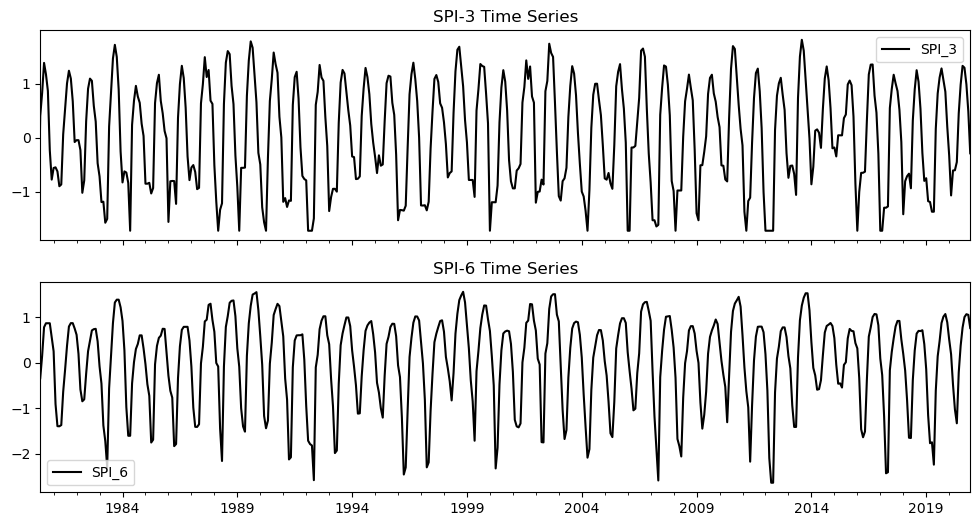

In [13]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

spi3.plot(ax=ax[0], color="black")
ax[0].set_title("SPI-3 Time Series")

spi6.plot(ax=ax[1], color="black")
ax[1].set_title("SPI-6 Time Series")

plt.show()


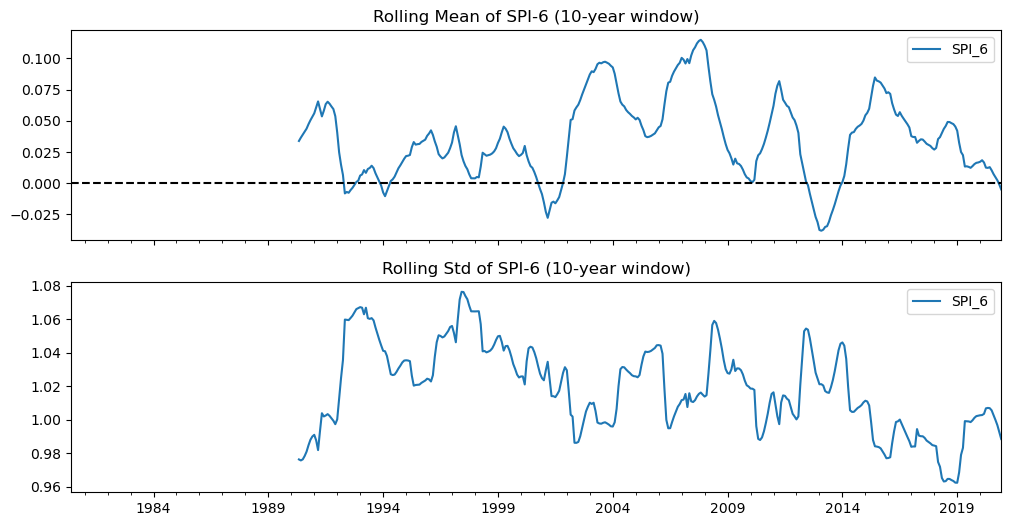

In [ ]:
window = 120  # 10 years (monthly)

rolling_mean = spi6.rolling(window).mean()
rolling_std = spi6.rolling(window).std()

fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

rolling_mean.plot(ax=ax[0])
ax[0].set_title("Rolling Mean of SPI-6 (10-year window)")
ax[0].axhline(0, color="k", linestyle="--")

rolling_std.plot(ax=ax[1])
ax[1].set_title("Rolling Std of SPI-6 (10-year window)")

plt.show()


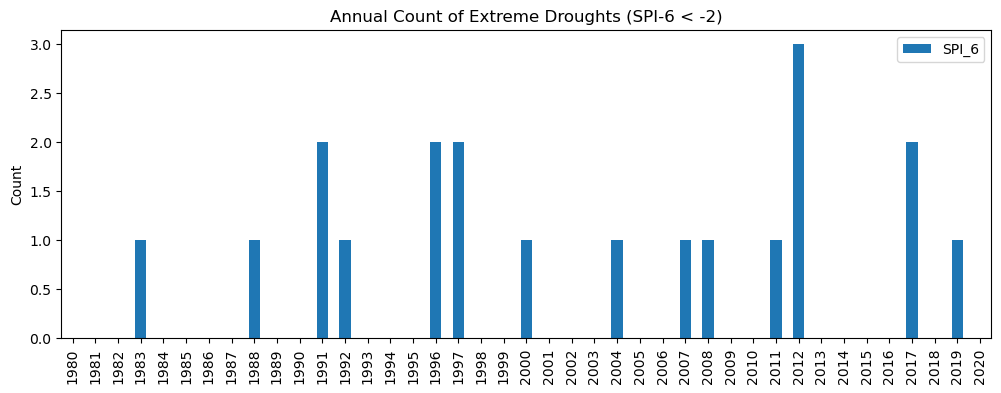

In [ ]:
extreme = spi6[spi6 < -2]

extreme_count = extreme.groupby(extreme.index.year).count()

extreme_count.plot(kind="bar", figsize=(12,4))
plt.title("Annual Count of Extreme Droughts (SPI-6 < -2)")
plt.ylabel("Count")
plt.show()


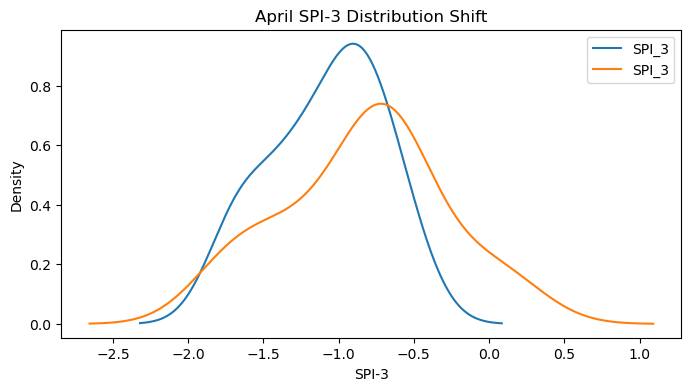

In [ ]:
spi_apr = spi3[spi3.index.month == 4]

early = spi_apr[spi_apr.index.year <= 2000]
late  = spi_apr[spi_apr.index.year > 2000]

fig, ax = plt.subplots(figsize=(8, 4))

early.plot(kind="kde", ax=ax, label="April SPI-3 (≤ 2000)")
late.plot(kind="kde", ax=ax, label="April SPI-3 (> 2000)")

ax.set_xlabel("SPI-3")
ax.set_ylabel("Density")
ax.set_title("April SPI-3 Distribution Shift")
ax.legend()

plt.show()


SPI-3 exhibits clear distributional shifts between pre-2000 and post-2000 periods, particularly in short-term drought variability. Based on this evidence, subsequent benchmarking focuses on SPI-3 with explicit temporal splits.

Month-conditioned kernel density estimates reveal clear temporal shifts in the distribution of SPI, particularly for short accumulation scales. This indicates non-stationary drought behavior even after accounting for seasonality, motivating explicit temporal evaluation of forecasting models

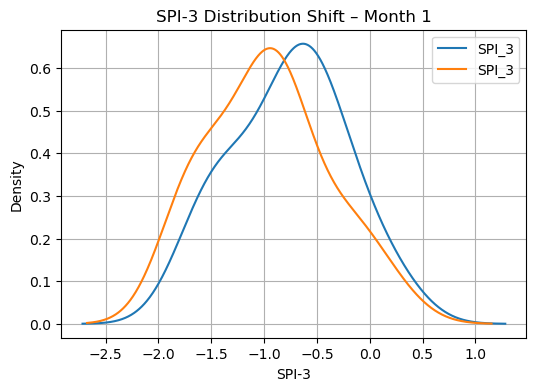

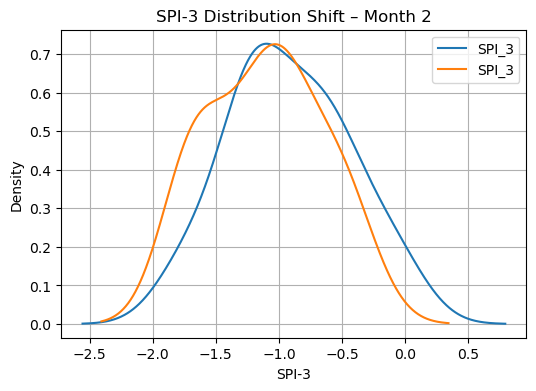

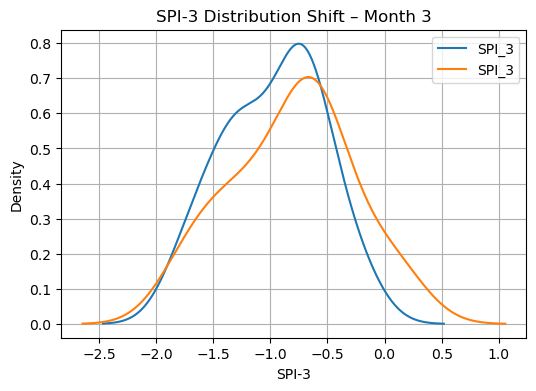

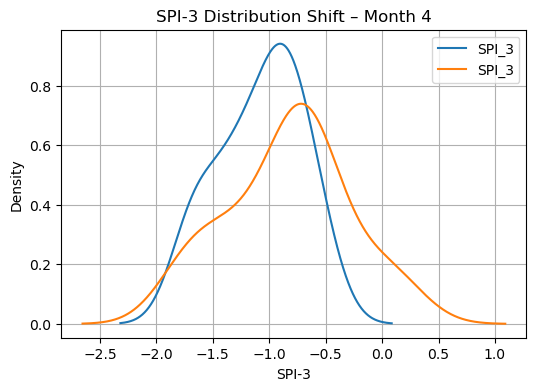

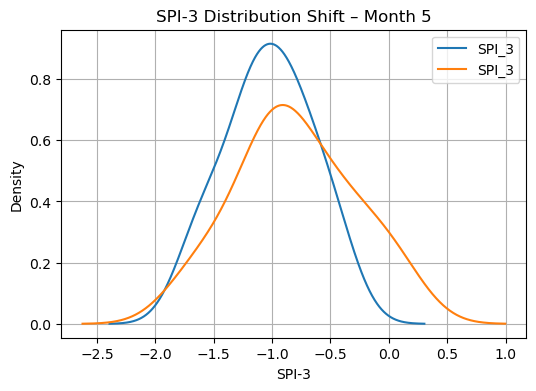

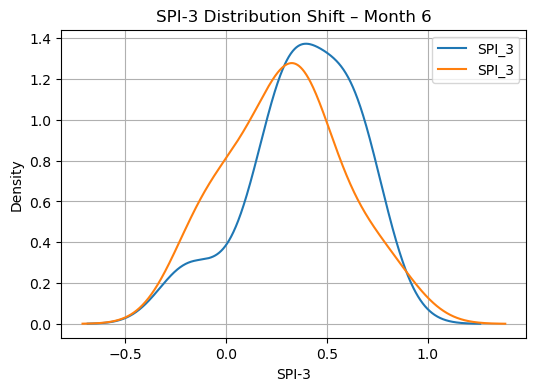

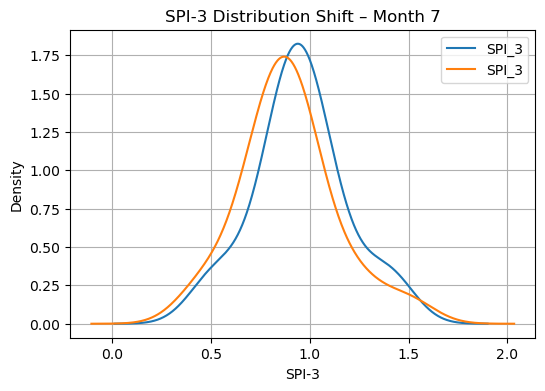

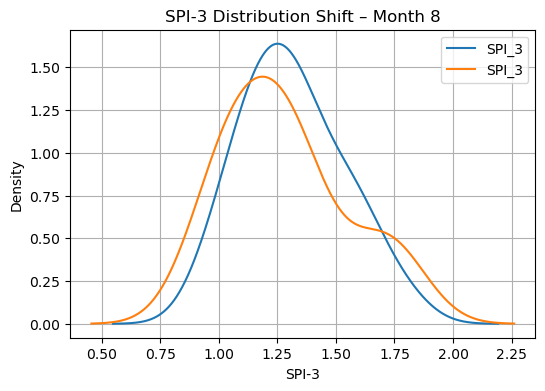

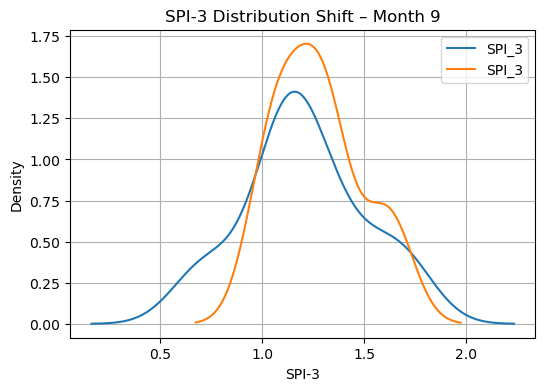

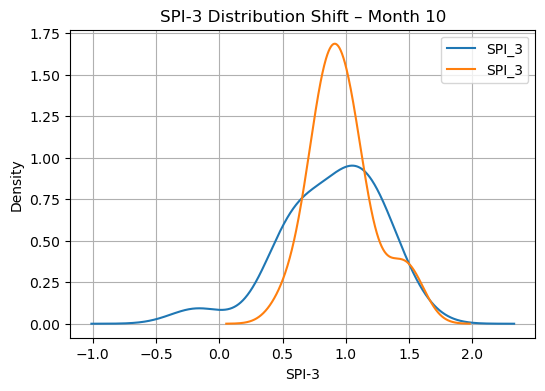

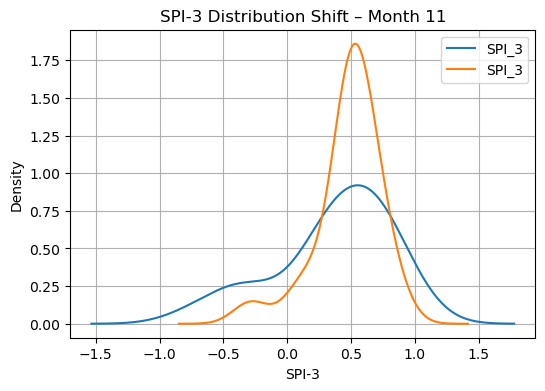

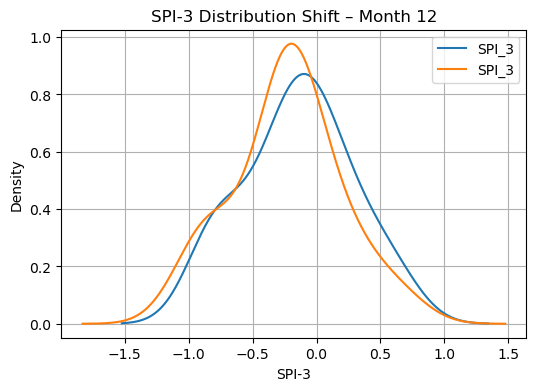

In [14]:
for m in range(1, 13):
    spi_m = spi3[spi3.index.month == m]

    early = spi_m[spi_m.index.year <= 2000]
    late  = spi_m[spi_m.index.year > 2000]

    if len(early) < 5 or len(late) < 5:
        continue

    fig, ax = plt.subplots(figsize=(6, 4))

    early.plot(kind="kde", ax=ax, label="≤ 2000")
    late.plot(kind="kde", ax=ax, label="> 2000")

    ax.set_title(f"SPI-3 Distribution Shift – Month {m}")
    ax.set_xlabel("SPI-3")
    ax.set_ylabel("Density")
    ax.legend()
    ax.grid(True)

    plt.show()


Although SPI is standardized to a reference climatology, month-wise KDEs reveal clear post-2000 distributional shifts, indicating conditional non-stationarity in the precipitation process. This helps explain the degradation of persistence and AR(1) skill under extreme drought conditions.